In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer

In [2]:
train = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv")
test = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv")

train.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
test.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')

ndvi_cols = [col for col in train.columns if "_N" in col]



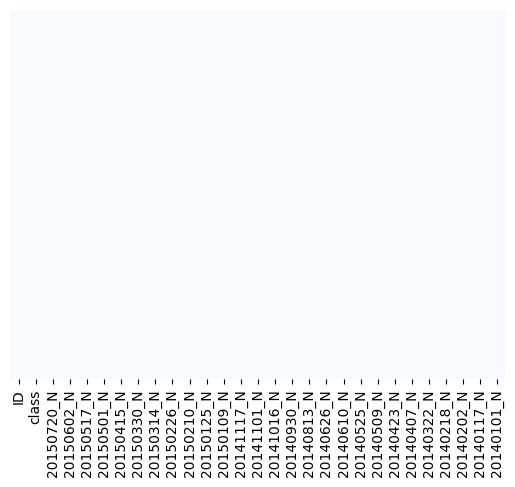

In [3]:
knn_imputer = KNNImputer(n_neighbors=3)
train[ndvi_cols] = knn_imputer.fit_transform(train[ndvi_cols])

sns.heatmap(train.isnull(), cmap='Blues', cbar=False, yticklabels=False, xticklabels=train.columns);

<Axes: title={'center': 'Class Distribution'}, xlabel='class'>

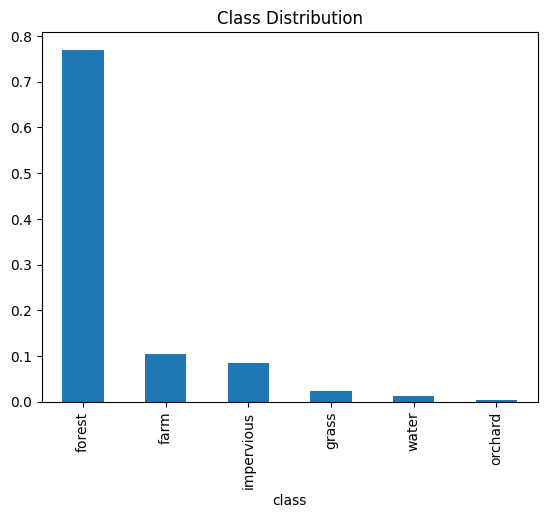

In [4]:
train['class'].value_counts(normalize=True).plot(kind='bar', title="Class Distribution")


In [5]:
def add_features(df):
    df['ndvi_mean'] = df[ndvi_cols].mean(axis=1)
    df['ndvi_std'] = df[ndvi_cols].std(axis=1)
    df['ndvi_min'] = df[ndvi_cols].min(axis=1)
    df['ndvi_max'] = df[ndvi_cols].max(axis=1)
    df['ndvi_range'] = df['ndvi_max'] - df['ndvi_min']
    df['ndvi_median'] = df[ndvi_cols].median(axis=1)
    return df

train = add_features(train)
test = add_features(test)

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import skew

# Add slope and skew
train['ndvi_slope'] = train[ndvi_cols].apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], axis=1)
test['ndvi_slope'] = test[ndvi_cols].apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], axis=1)

train['ndvi_skew'] = train[ndvi_cols].apply(skew, axis=1)
test['ndvi_skew'] = test[ndvi_cols].apply(skew, axis=1)

# PCA
pca = PCA(n_components=5, random_state=42)
train_pca = pca.fit_transform(train[ndvi_cols])
test_pca = pca.transform(test[ndvi_cols])

for i in range(5):
    train[f'pca_{i}'] = train_pca[:, i]
    test[f'pca_{i}'] = test_pca[:, i]

# Update feature columns
feature_cols = ndvi_cols + ['ndvi_mean', 'ndvi_std', 'ndvi_min', 'ndvi_max', 'ndvi_range',
                            'ndvi_median', 'ndvi_slope', 'ndvi_skew'] + [f'pca_{i}' for i in range(5)]

# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(train[feature_cols])
X_test_poly = poly.transform(test[feature_cols])

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, train['class'], test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Validation
val_preds = model.predict(X_val)
acc = accuracy_score(y_val, val_preds)
print("Validation Accuracy:", round(acc * 100, 2), "%")

# Predict on test set
test_preds = model.predict(X_test_scaled)

# Submission
submission = pd.DataFrame({'ID': test['ID'], 'class': test_preds})
submission.to_csv("submission.csv", index=False)

Validation Accuracy: 96.25 %
